In [170]:
import ee
import rasterio
import numpy as np
from pprint import pprint
from IPython.display import display
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib import colors

In [171]:
from channel_classifier.internal.ee_utils import compute_error_image, download_tiff, get_landsat_image, form_labelled_image

In [172]:
ee.Initialize()

In [173]:
MODIS_LABELS = ['']

In [174]:
path, row = [7, 65] # Ucayali
year, month, day = [2014, 9, 7]
img = get_landsat_image(path, row, year, month, day)

In [175]:
vis_params = {'bands' : 'B5, B6, B4'} # XXX: bands should be a string, not list...
url = img.getThumbUrl(vis_params)
print(ee.Date(img.get('system:time_start')).format('Y-M-d').getInfo())

2014-9-7


In [176]:
Image(url=url)

In [185]:
used_bands = ['B{}'.format(x) for x in np.arange(1, 8)]
stacked = form_labelled_image(path, row, year, month, day, bands=used_bands)

In [186]:
filename = download_tiff(stacked, scale=200)

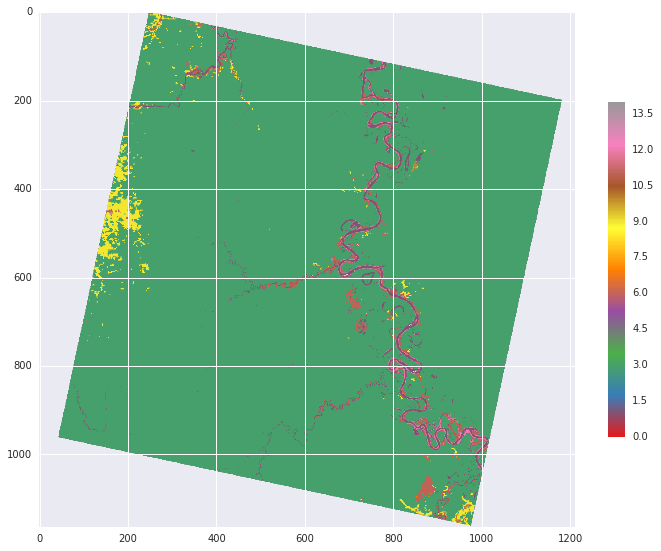

In [187]:
cmap = colors.ListedColormap(['white', 'blue', 'red'])
bounds = [0, 0.5, 1.5, 2]
norm = colors.BoundaryNorm(bounds, cmap.N)
with rasterio.open(filename) as r:
    i = r.count
    labels = r.read(i)
    labels[labels == 0] = np.nan
    label_values = list(np.unique(labels[~np.isnan(labels)]))
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(labels, cmap='Set1', vmin=0)#, cmap=cmap, norm=norm)
cb = plt.colorbar(im, ax=ax, shrink=0.5)#, label='Class label', ticks=[0, 1, 2])
#cb.ax.set_yticklabels(label_values);

In [189]:
bands = stacked.bandNames().getInfo()
print(bands)

[u'B1', u'B2', u'B3', u'B4', u'B5', u'B6', u'B7', u'label']


In [190]:
training = stacked.sample(numPixels=10000, seed=0).select(bands).filter(ee.Filter.neq('label', 0))
validation = stacked.sample(numPixels=10000, seed=1).select(bands).filter(ee.Filter.neq('label', 0))

In [191]:
classifier = ee.Classifier.randomForest(10).train(training, 'label')

In [192]:
classified = stacked.classify(classifier, 'classification')

In [193]:
validated = validation.classify(classifier, 'classification')
accuracy = validated.errorMatrix('label', 'classification')
print(accuracy.accuracy().getInfo())

0.963985594238


In [194]:
error = compute_error_image(clipped_labels, classified.clip(img.geometry()), 1)

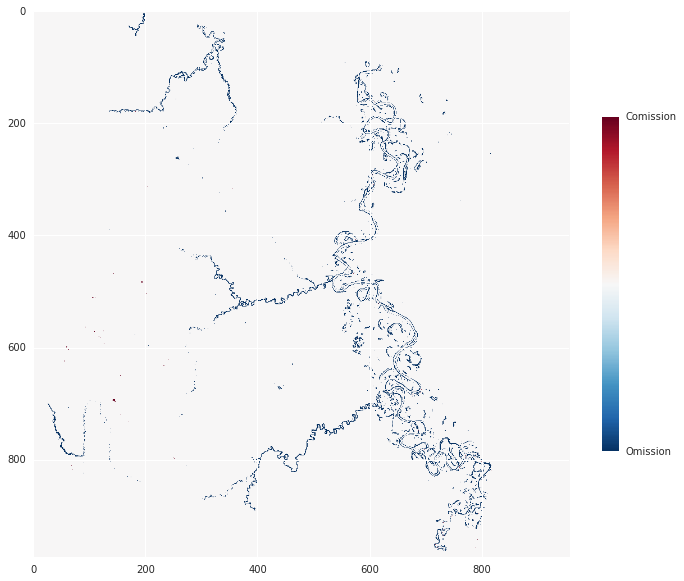

In [195]:
filename = download_tiff(error, scale=240)
with rasterio.open(filename) as r:
    err = r.read(1)
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(err, cmap='RdBu_r', vmin=-1, vmax=1) #, cmap=cmap, norm=norm)
cb = plt.colorbar(im, ax=ax, shrink=0.5, ticks=[-1, 0, 1])
cb.ax.set_yticklabels(['Omission', '', 'Comission']);

In [196]:
filename = download_tiff(classified, scale=200)

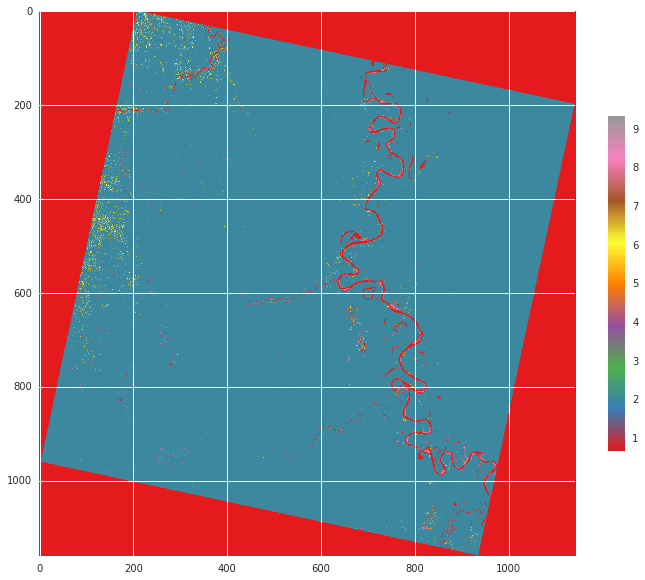

In [203]:
cmap = colors.ListedColormap(['white', 'blue', 'red'])
bounds = [0, 0.5, 1.5, 2]
norm = colors.BoundaryNorm(bounds, cmap.N)
with rasterio.open(filename) as r:
    i = r.count
    labels = r.read(i).astype(float)
    labels[labels == 0] = np.nan
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(labels, cmap='Set1')#, cmap=cmap, norm=norm)
cb = plt.colorbar(im, ax=ax, shrink=0.5)#, label='Class label', ticks=[0, 1, 2])
cb.ax.set_yticklabels(np.arange(1, 17));